In [2]:
print("Backprop")

Backprop


In [2]:
import wandb
wandb.login()  # This will prompt you to enter your API key


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: da24m016 (da24m016-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin


True

In [3]:
import wandb

# Initialize a wandb run
wandb.init(project="my-awesome-project")


In [3]:
# Cell 2: Define Model Functions and NeuralNetwork Class
import numpy as np

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(float)

def identity(x):
    return x

def didentity(x):
    return np.ones_like(x)

def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

# Loss functions
def cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    return loss

def mse_loss(y_pred, y_true):
    loss = np.mean(0.5 * np.square(y_true - y_pred))
    return loss

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation, weight_init, loss_func):
        # Select activation function
        self.activation_str = activation.lower()
        if self.activation_str == 'sigmoid':
            self.activation = sigmoid
            self.activation_deriv = dsigmoid
        elif self.activation_str == 'tanh':
            self.activation = tanh
            self.activation_deriv = dtanh
        elif self.activation_str == 'relu':
            self.activation = relu
            self.activation_deriv = drelu
        elif self.activation_str == 'identity':
            self.activation = identity
            self.activation_deriv = didentity
        else:
            raise ValueError("Unknown activation function.")
        
        # Select loss function
        self.loss_func_name = loss_func.lower()
        if self.loss_func_name == 'cross_entropy':
            self.loss_func = cross_entropy_loss
        elif self.loss_func_name == 'mean_squared_error':
            self.loss_func = mse_loss
        else:
            raise ValueError("Unknown loss function.")
        
        # Define layer sizes: input -> hidden layers -> output
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.num_layers = len(self.layer_sizes) - 1
        
        # Initialize weights and biases
        self.params = {}
        for i in range(1, len(self.layer_sizes)):
            if weight_init.lower() == 'xavier':
                limit = np.sqrt(6 / (self.layer_sizes[i-1] + self.layer_sizes[i]))
                self.params['W' + str(i)] = np.random.uniform(-limit, limit, (self.layer_sizes[i-1], self.layer_sizes[i]))
            else:  # 'random'
                self.params['W' + str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * 0.01
            self.params['b' + str(i)] = np.zeros((1, self.layer_sizes[i]))
    
    def forward(self, X):
        cache = {}
        A = X
        cache['A0'] = A
        # Hidden layers
        for i in range(1, self.num_layers):
            Z = np.dot(A, self.params['W' + str(i)]) + self.params['b' + str(i)]
            cache['Z' + str(i)] = Z
            A = self.activation(Z)
            cache['A' + str(i)] = A
        # Output layer with softmax
        Z = np.dot(A, self.params['W' + str(self.num_layers)]) + self.params['b' + str(self.num_layers)]
        cache['Z' + str(self.num_layers)] = Z
        A = softmax(Z)
        cache['A' + str(self.num_layers)] = A
        return A, cache
    
    def compute_loss(self, y_pred, y_true):
        return self.loss_func(y_pred, y_true)
    
    def backward(self, X, y_true, cache):
        grads = {}
        m = X.shape[0]
        A_final = cache['A' + str(self.num_layers)]
        if self.loss_func_name == 'cross_entropy':
            dZ = (A_final - y_true) / m
        else:
            dZ = (A_final - y_true) / m
        
        # Output layer gradients
        A_prev = cache['A' + str(self.num_layers - 1)]
        grads['dW' + str(self.num_layers)] = np.dot(A_prev.T, dZ)
        grads['db' + str(self.num_layers)] = np.sum(dZ, axis=0, keepdims=True)
        
        # Backpropagation through hidden layers
        for i in range(self.num_layers - 1, 0, -1):
            dA = np.dot(dZ, self.params['W' + str(i + 1)].T)
            Z = cache['Z' + str(i)]
            dZ = dA * self.activation_deriv(Z)
            A_prev = cache['A' + str(i - 1)]
            grads['dW' + str(i)] = np.dot(A_prev.T, dZ)
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True)
        
        return grads


In [5]:
# Cell 3: Define the Optimizer Class
class Optimizer:
    def __init__(self, params, optimizer_name, learning_rate, momentum=0.5,
                 beta=0.5, beta1=0.5, beta2=0.5, epsilon=1e-6, weight_decay=0.0):
        self.optimizer_name = optimizer_name.lower()
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.t = 0  # timestep for Adam/Nadam
        
        # Initialize optimizer states
        self.v = {}  # For momentum or Adam's first moment
        self.s = {}  # For RMSProp or Adam's second moment
        for key, val in params.items():
            self.v[key] = np.zeros_like(val)
            self.s[key] = np.zeros_like(val)
        self.param_keys = list(params.keys())
    
    def update(self, params, grads):
        self.t += 1
        for key in self.param_keys:
            grad = grads['d' + key]
            # Apply weight decay to weights only
            if key.startswith('W'):
                grad += self.weight_decay * params[key]
            if self.optimizer_name == 'sgd':
                params[key] -= self.learning_rate * grad
            elif self.optimizer_name == 'momentum':
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad
                params[key] += self.v[key]
            elif self.optimizer_name in ['nag', 'nesterov']:
                v_prev = self.v[key].copy()
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad
                params[key] += -self.momentum * v_prev + (1 + self.momentum) * self.v[key]
            elif self.optimizer_name == 'rmsprop':
                self.s[key] = self.beta * self.s[key] + (1 - self.beta) * (grad ** 2)
                params[key] -= self.learning_rate * grad / (np.sqrt(self.s[key]) + self.epsilon)
            elif self.optimizer_name == 'adam':
                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grad
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (grad ** 2)
                v_corr = self.v[key] / (1 - self.beta1 ** self.t)
                s_corr = self.s[key] / (1 - self.beta2 ** self.t)
                params[key] -= self.learning_rate * v_corr / (np.sqrt(s_corr) + self.epsilon)
            elif self.optimizer_name == 'nadam':
                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grad
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (grad ** 2)
                v_corr = self.v[key] / (1 - self.beta1 ** self.t)
                s_corr = self.s[key] / (1 - self.beta2 ** self.t)
                params[key] -= self.learning_rate * (self.beta1 * v_corr + (1 - self.beta1) * grad) / (np.sqrt(s_corr) + self.epsilon)
            else:
                raise ValueError("Unknown optimizer: " + self.optimizer_name)


In [6]:
# Cell 4: Utility Functions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

def load_data(dataset="fashion_mnist"):
    if dataset == "fashion_mnist":
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    elif dataset == "mnist":
        from keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        raise ValueError("Unknown dataset.")
    
    # Normalize and reshape data
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    # Split 10% of training data for validation
    split_index = int(0.9 * X_train.shape[0])
    X_val = X_train[split_index:]
    y_val = y_train[split_index:]
    X_train = X_train[:split_index]
    y_train = y_train[:split_index]
    return X_train, y_train, X_val, y_val, X_test, y_test

def train_model(network, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size):
    num_samples = X_train.shape[0]
    steps_per_epoch = num_samples // batch_size
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0
        epoch_acc = 0
        
        for step in range(steps_per_epoch):
            start = step * batch_size
            end = start + batch_size
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            # Forward pass
            y_pred, cache = network.forward(X_batch)
            loss = network.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            # Accuracy calculation
            predictions = np.argmax(y_pred, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            acc = np.mean(predictions == true_labels)
            epoch_acc += acc
            # Backward pass and update
            grads = network.backward(X_batch, y_batch, cache)
            optimizer.update(network.params, grads)
        
        epoch_loss /= steps_per_epoch
        epoch_acc /= steps_per_epoch
        
        # Evaluate on validation data
        y_val_pred, _ = network.forward(X_val)
        val_loss = network.compute_loss(y_val_pred, y_val)
        predictions_val = np.argmax(y_val_pred, axis=1)
        true_labels_val = np.argmax(y_val, axis=1)
        val_acc = np.mean(predictions_val == true_labels_val)
        
        print(f"Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
    return network

def evaluate_model(network, X_test, y_test):
    y_pred, _ = network.forward(X_test)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    test_acc = np.mean(predictions == true_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    return predictions, true_labels, test_acc

def plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


4431872/4422102 [==============================] - 1s 0us/step
Epoch 1/5: Loss=0.5225, Acc=0.8129, Val Loss=0.4337, Val Acc=0.8410
Epoch 2/5: Loss=0.3862, Acc=0.8597, Val Loss=0.3725, Val Acc=0.8660
Epoch 3/5: Loss=0.3447, Acc=0.8743, Val Loss=0.3380, Val Acc=0.8752
Epoch 4/5: Loss=0.3256, Acc=0.8800, Val Loss=0.3471, Val Acc=0.8682
Epoch 5/5: Loss=0.3100, Acc=0.8853, Val Loss=0.3504, Val Acc=0.8748
Test Accuracy: 0.8663


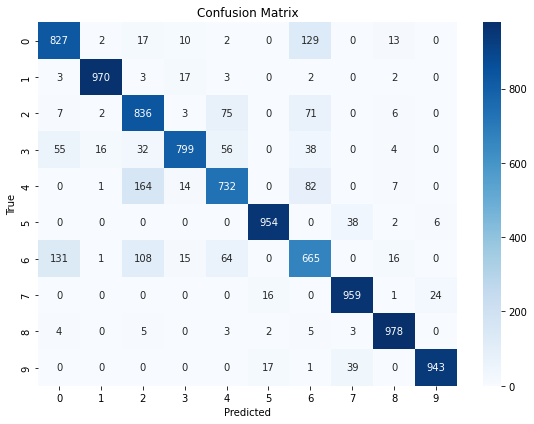

wandb: ERROR Control-C detected -- Run data was not synced


In [13]:
# Cell 5: Main Training Loop & Wandb Initialization
import wandb

# Initialize a new Wandb run
wandb.init(project="DL_Assignment_01")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 5
config.num_layers = 2      # Example: 2 hidden layers
config.hidden_size = 64    # Example: 64 neurons per hidden layer
config.activation = "relu"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "adam"  # Options: sgd, momentum, nag, rmsprop, adam, nadam
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0001

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, config.activation, config.weight_init, config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)

# Plot the confusion matrix
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb (update project and entity with your own values)
wandb.init(project="DL_Assignment_01")

# Load Fashion-MNIST data
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Create a grid plot: 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# For each class, find the first image and plot it
for i, ax in enumerate(axes.flat):
    # Find the index of the first occurrence of class i
    idx = np.where(y_train == i)[0][0]
    # Plot the image in grayscale
    ax.imshow(X_train[idx], cmap="gray")
    ax.set_title(class_names[i])
    ax.axis("off")

plt.tight_layout()

# Log the grid plot to Wandb
wandb.log({"Sample Images": wandb.Image(fig)})

# Display the plot in the notebook
plt.show()

wandb.finish()


In [14]:
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'random',  # using random search for efficiency
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

# Create the sweep and print the sweep_id
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: 1ztchdgb
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/1ztchdgb
Sweep ID: 1ztchdgb


In [7]:
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization instead of random search
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: pu8149xm
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/pu8149xm
Sweep ID: pu8149xm


In [8]:
def sweep_train():
    # Initialize the Wandb run (this pulls hyperparameters from the sweep config)
    wandb.init()
    config = wandb.config
    
    # Load the data using the standard Fashion-MNIST split
    X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
    input_size = X_train.shape[1]
    output_size = 10  # for 10 classes

    # Create a list of hidden layer sizes: repeat 'hidden_size' for 'num_layers' times
    hidden_sizes = [config.hidden_size] * config.num_layers

    # Initialize the neural network and optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func="cross_entropy")
    
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=0.9,  # you can set default values or include these in the sweep config as well
                          beta=0.9,
                          beta1=0.9,
                          beta2=0.999,
                          epsilon=1e-8,
                          weight_decay=config.weight_decay)
    
    # Train the model using the training function defined earlier
    network = train_model(network, optimizer, X_train, y_train, X_val, y_val, 
                          epochs=config.epochs, batch_size=config.batch_size)
    
    # Evaluate on the validation set
    y_val_pred, _ = network.forward(X_val)
    val_loss = network.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    wandb.finish()


In [9]:
# Launch the sweep agent; this will run the training function with different hyperparameter configurations.
wandb.agent(sweep_id, function=sweep_train, count=20)


wandb: Agent Starting Run: p4zcxa4d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3026, Acc=0.0980, Val Loss=2.3027, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0987, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3028, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0989, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3028, Val Acc=0.0973
Epoch 6/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1011, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1011, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1012, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▂▄▃▄▆███▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▅▆▄▄▃▃▁▁
val_accuracy,▁▁▁▁█▁▁▁▁▁
val_loss,▁▅█▆▇▆█▇▇▅
accuracy,0.10076
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30275


wandb: Agent Starting Run: zeyrkk2k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.3516, Acc=0.0990, Val Loss=2.3082, Val Acc=0.0925
Epoch 2/5: Loss=2.3035, Acc=0.0998, Val Loss=2.3024, Val Acc=0.0973
Epoch 3/5: Loss=2.3030, Acc=0.0973, Val Loss=2.3025, Val Acc=0.1055
Epoch 4/5: Loss=2.3029, Acc=0.0999, Val Loss=2.3026, Val Acc=0.1027
Epoch 5/5: Loss=2.3029, Acc=0.1010, Val Loss=2.3026, Val Acc=0.1050


accuracy,▄▆▁▆█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▁▁▁▁
val_accuracy,▁▄█▆█
val_loss,█▁▁▁▁
accuracy,0.10105
epoch,5
final_val_accuracy,0.105
final_val_loss,2.30261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qgp8m9jh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.5599, Acc=0.5354, Val Loss=1.1588, Val Acc=0.6647
Epoch 2/5: Loss=1.0323, Acc=0.6800, Val Loss=0.9163, Val Acc=0.7023
Epoch 3/5: Loss=0.8704, Acc=0.7156, Val Loss=0.8049, Val Acc=0.7302
Epoch 4/5: Loss=0.7829, Acc=0.7417, Val Loss=0.7361, Val Acc=0.7570
Epoch 5/5: Loss=0.7245, Acc=0.7602, Val Loss=0.6879, Val Acc=0.7675


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▂▁
accuracy,0.76023
epoch,5
final_val_accuracy,0.7675
final_val_loss,0.68787


wandb: Agent Starting Run: xsm1wgz5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3058, Acc=0.0995, Val Loss=2.3052, Val Acc=0.1050
Epoch 2/10: Loss=2.3050, Acc=0.1003, Val Loss=2.3056, Val Acc=0.1055
Epoch 3/10: Loss=2.3047, Acc=0.1012, Val Loss=2.3054, Val Acc=0.1050
Epoch 4/10: Loss=2.3044, Acc=0.1002, Val Loss=2.3053, Val Acc=0.1027
Epoch 5/10: Loss=2.3044, Acc=0.1029, Val Loss=2.3024, Val Acc=0.1050
Epoch 6/10: Loss=2.3041, Acc=0.0999, Val Loss=2.3033, Val Acc=0.0985
Epoch 7/10: Loss=2.3035, Acc=0.1051, Val Loss=2.3047, Val Acc=0.1027
Epoch 8/10: Loss=2.3034, Acc=0.1025, Val Loss=2.3031, Val Acc=0.0985
Epoch 9/10: Loss=2.3027, Acc=0.1042, Val Loss=2.3017, Val Acc=0.0942
Epoch 10/10: Loss=2.3020, Acc=0.1054, Val Loss=2.3018, Val Acc=0.1032


accuracy,▁▂▃▂▅▁█▅▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▆▅▅▅▄▄▂▁
val_accuracy,███▆█▄▆▄▁▇
val_loss,▇██▇▂▄▆▄▁▁
accuracy,0.10541
epoch,10
final_val_accuracy,0.10317
final_val_loss,2.3018


wandb: Agent Starting Run: bb3ijrb9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3026, Acc=0.0979, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0983, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1003, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▂█▅▆▇█▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▁▂▂▂▁▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▅▆▆▇▇███
accuracy,0.10024
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9a4zmwe with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.0056, Acc=0.3787, Val Loss=1.6844, Val Acc=0.5960
Epoch 2/5: Loss=1.4128, Acc=0.6239, Val Loss=1.1644, Val Acc=0.6587
Epoch 3/5: Loss=1.0375, Acc=0.6661, Val Loss=0.9165, Val Acc=0.6923
Epoch 4/5: Loss=0.8709, Acc=0.6978, Val Loss=0.8065, Val Acc=0.7210
Epoch 5/5: Loss=0.7878, Acc=0.7211, Val Loss=0.7437, Val Acc=0.7397


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
accuracy,0.7211
epoch,5
final_val_accuracy,0.73967
final_val_loss,0.74372


wandb: Agent Starting Run: p3e0uwtz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.3026, Acc=0.1050, Val Loss=2.3026, Val Acc=0.0948
Epoch 2/5: Loss=2.3026, Acc=0.1092, Val Loss=2.3026, Val Acc=0.0987
Epoch 3/5: Loss=2.3026, Acc=0.1314, Val Loss=2.3026, Val Acc=0.1095
Epoch 4/5: Loss=2.3026, Acc=0.1056, Val Loss=2.3026, Val Acc=0.1252
Epoch 5/5: Loss=2.3026, Acc=0.1183, Val Loss=2.3026, Val Acc=0.1417


accuracy,▁▂█▁▅
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▃▁
val_accuracy,▁▂▃▆█
val_loss,█▅▁▁▁
accuracy,0.11827
epoch,5
final_val_accuracy,0.14167
final_val_loss,2.3026


wandb: Agent Starting Run: l5brcx7g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.0016, Acc=0.3362, Val Loss=1.5218, Val Acc=0.5260
Epoch 2/10: Loss=1.1430, Acc=0.6355, Val Loss=0.8952, Val Acc=0.6937
Epoch 3/10: Loss=0.8205, Acc=0.7090, Val Loss=0.7415, Val Acc=0.7385
Epoch 4/10: Loss=0.7133, Acc=0.7474, Val Loss=0.6686, Val Acc=0.7563
Epoch 5/10: Loss=0.6513, Acc=0.7732, Val Loss=0.6235, Val Acc=0.7770
Epoch 6/10: Loss=0.6087, Acc=0.7879, Val Loss=0.5860, Val Acc=0.7965
Epoch 7/10: Loss=0.5775, Acc=0.8003, Val Loss=0.5587, Val Acc=0.8037
Epoch 8/10: Loss=0.5525, Acc=0.8085, Val Loss=0.5371, Val Acc=0.8125
Epoch 9/10: Loss=0.5320, Acc=0.8146, Val Loss=0.5243, Val Acc=0.8180
Epoch 10/10: Loss=0.5170, Acc=0.8202, Val Loss=0.5069, Val Acc=0.8225


accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.82017
epoch,10
final_val_accuracy,0.8225
final_val_loss,0.50694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9su5rfok with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.2756, Acc=0.2617, Val Loss=2.2982, Val Acc=0.1488
Epoch 2/10: Loss=2.3019, Acc=0.1125, Val Loss=2.3028, Val Acc=0.0942
Epoch 3/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3027, Val Acc=0.1003
Epoch 4/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.1003
Epoch 5/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.1003
Epoch 6/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3027, Val Acc=0.1003
Epoch 7/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█████████
val_accuracy,█▁▂▂▂▂▁▁▁▁
val_loss,▁█████████
accuracy,0.10085
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30275


wandb: Agent Starting Run: l28oiyjw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.6941, Acc=0.4941, Val Loss=1.1267, Val Acc=0.6755
Epoch 2/5: Loss=0.9371, Acc=0.6951, Val Loss=0.8017, Val Acc=0.7328
Epoch 3/5: Loss=0.7554, Acc=0.7432, Val Loss=0.6974, Val Acc=0.7647
Epoch 4/5: Loss=0.6734, Acc=0.7704, Val Loss=0.6358, Val Acc=0.7823
Epoch 5/5: Loss=0.6202, Acc=0.7891, Val Loss=0.5927, Val Acc=0.7930


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
accuracy,0.78912
epoch,5
final_val_accuracy,0.793
final_val_loss,0.59273


wandb: Agent Starting Run: 97bzlwqr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.1960, Acc=0.1753, Val Loss=2.0840, Val Acc=0.2487
Epoch 2/5: Loss=1.9957, Acc=0.3135, Val Loss=1.9116, Val Acc=0.3978
Epoch 3/5: Loss=1.8412, Acc=0.4353, Val Loss=1.7707, Val Acc=0.4785
Epoch 4/5: Loss=1.7133, Acc=0.5003, Val Loss=1.6538, Val Acc=0.5258
Epoch 5/5: Loss=1.6073, Acc=0.5381, Val Loss=1.5565, Val Acc=0.5537


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▂▁
val_accuracy,▁▄▆▇█
val_loss,█▆▄▂▁
accuracy,0.53815
epoch,5
final_val_accuracy,0.55367
final_val_loss,1.55648


wandb: Agent Starting Run: qax4nvez with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.1527, Acc=0.3143, Val Loss=1.9427, Val Acc=0.4903
Epoch 2/5: Loss=1.6328, Acc=0.5507, Val Loss=1.3091, Val Acc=0.6282
Epoch 3/5: Loss=1.1279, Acc=0.6432, Val Loss=0.9700, Val Acc=0.6677
Epoch 4/5: Loss=0.9036, Acc=0.6846, Val Loss=0.8248, Val Acc=0.7008
Epoch 5/5: Loss=0.7984, Acc=0.7175, Val Loss=0.7521, Val Acc=0.7257


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
accuracy,0.71749
epoch,5
final_val_accuracy,0.72567
final_val_loss,0.75213


wandb: Agent Starting Run: n94e72ut with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.2242, Acc=0.4305, Val Loss=2.2632, Val Acc=0.5625
Epoch 2/10: Loss=2.2882, Acc=0.3440, Val Loss=2.3001, Val Acc=0.1313
Epoch 3/10: Loss=2.3018, Acc=0.1014, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▆▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁▇████████
val_accuracy,█▂▁▁▁▁▁▁▁▁
val_loss,▁█████████
accuracy,0.10086
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30277


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xatjpda3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.2864, Acc=0.1650, Val Loss=2.2769, Val Acc=0.1777
Epoch 2/5: Loss=2.2692, Acc=0.1978, Val Loss=2.2640, Val Acc=0.2128
Epoch 3/5: Loss=2.2604, Acc=0.2387, Val Loss=2.2578, Val Acc=0.2553
Epoch 4/5: Loss=2.2566, Acc=0.2761, Val Loss=2.2556, Val Acc=0.2913
Epoch 5/5: Loss=2.2559, Acc=0.3048, Val Loss=2.2559, Val Acc=0.3160


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▃▅▇█
val_loss,█▄▂▁▁
accuracy,0.30483
epoch,5
final_val_accuracy,0.316
final_val_loss,2.25587


wandb: Agent Starting Run: uoci70xl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=0.6924, Acc=0.7665, Val Loss=0.4951, Val Acc=0.8218
Epoch 2/10: Loss=0.4510, Acc=0.8400, Val Loss=0.4310, Val Acc=0.8462
Epoch 3/10: Loss=0.4049, Acc=0.8550, Val Loss=0.3902, Val Acc=0.8567
Epoch 4/10: Loss=0.3748, Acc=0.8664, Val Loss=0.3753, Val Acc=0.8638
Epoch 5/10: Loss=0.3551, Acc=0.8720, Val Loss=0.3781, Val Acc=0.8660
Epoch 6/10: Loss=0.3402, Acc=0.8772, Val Loss=0.3493, Val Acc=0.8735
Epoch 7/10: Loss=0.3265, Acc=0.8818, Val Loss=0.3453, Val Acc=0.8782
Epoch 8/10: Loss=0.3154, Acc=0.8849, Val Loss=0.3597, Val Acc=0.8673
Epoch 9/10: Loss=0.3059, Acc=0.8889, Val Loss=0.3597, Val Acc=0.8682
Epoch 10/10: Loss=0.2983, Acc=0.8921, Val Loss=0.3494, Val Acc=0.8755


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇█▇▇█
val_loss,█▅▃▂▃▁▁▂▂▁
accuracy,0.89213
epoch,10
final_val_accuracy,0.8755
final_val_loss,0.34938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ytx8soot with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.6546, Acc=0.5269, Val Loss=1.2148, Val Acc=0.6670
Epoch 2/5: Loss=1.0538, Acc=0.6984, Val Loss=0.9246, Val Acc=0.7210
Epoch 3/5: Loss=0.8698, Acc=0.7321, Val Loss=0.8033, Val Acc=0.7448
Epoch 4/5: Loss=0.7774, Acc=0.7531, Val Loss=0.7334, Val Acc=0.7660
Epoch 5/5: Loss=0.7178, Acc=0.7676, Val Loss=0.6853, Val Acc=0.7763


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.76765
epoch,5
final_val_accuracy,0.77633
final_val_loss,0.68527


wandb: Agent Starting Run: mxlfgkz9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=0.6404, Acc=0.7802, Val Loss=0.4511, Val Acc=0.8355
Epoch 2/10: Loss=0.4262, Acc=0.8505, Val Loss=0.4129, Val Acc=0.8532
Epoch 3/10: Loss=0.3861, Acc=0.8633, Val Loss=0.3741, Val Acc=0.8627
Epoch 4/10: Loss=0.3599, Acc=0.8721, Val Loss=0.3696, Val Acc=0.8680
Epoch 5/10: Loss=0.3406, Acc=0.8778, Val Loss=0.3558, Val Acc=0.8700
Epoch 6/10: Loss=0.3260, Acc=0.8819, Val Loss=0.3563, Val Acc=0.8727
Epoch 7/10: Loss=0.3131, Acc=0.8867, Val Loss=0.3394, Val Acc=0.8800
Epoch 8/10: Loss=0.3034, Acc=0.8882, Val Loss=0.3330, Val Acc=0.8808
Epoch 9/10: Loss=0.2925, Acc=0.8938, Val Loss=0.3293, Val Acc=0.8810
Epoch 10/10: Loss=0.2831, Acc=0.8956, Val Loss=0.3448, Val Acc=0.8737


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇███▇
val_loss,█▆▄▃▃▃▂▁▁▂
accuracy,0.89558
epoch,10
final_val_accuracy,0.87367
final_val_loss,0.34478


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3xe5y2p2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6696, Acc=0.7763, Val Loss=0.4458, Val Acc=0.8385
Epoch 2/5: Loss=0.4286, Acc=0.8481, Val Loss=0.4058, Val Acc=0.8497
Epoch 3/5: Loss=0.3913, Acc=0.8604, Val Loss=0.3955, Val Acc=0.8547
Epoch 4/5: Loss=0.3701, Acc=0.8669, Val Loss=0.3829, Val Acc=0.8588
Epoch 5/5: Loss=0.3547, Acc=0.8723, Val Loss=0.3819, Val Acc=0.8598


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▂▁▁
accuracy,0.87229
epoch,5
final_val_accuracy,0.85983
final_val_loss,0.38195


wandb: Agent Starting Run: zwhqyhqp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6522, Acc=0.7708, Val Loss=0.4775, Val Acc=0.8372
Epoch 2/5: Loss=0.4268, Acc=0.8488, Val Loss=0.4084, Val Acc=0.8565
Epoch 3/5: Loss=0.3904, Acc=0.8607, Val Loss=0.3856, Val Acc=0.8602
Epoch 4/5: Loss=0.3663, Acc=0.8679, Val Loss=0.3664, Val Acc=0.8700
Epoch 5/5: Loss=0.3463, Acc=0.8756, Val Loss=0.3546, Val Acc=0.8730


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▅▇█
val_loss,█▄▃▂▁
accuracy,0.87563
epoch,5
final_val_accuracy,0.873
final_val_loss,0.35461


wandb: Agent Starting Run: 7wt3iqpy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6709, Acc=0.7713, Val Loss=0.4742, Val Acc=0.8353
Epoch 2/5: Loss=0.4394, Acc=0.8451, Val Loss=0.4106, Val Acc=0.8535
Epoch 3/5: Loss=0.3942, Acc=0.8608, Val Loss=0.3835, Val Acc=0.8625
Epoch 4/5: Loss=0.3684, Acc=0.8689, Val Loss=0.3649, Val Acc=0.8658
Epoch 5/5: Loss=0.3477, Acc=0.8752, Val Loss=0.3570, Val Acc=0.8698


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▁▁
accuracy,0.87519
epoch,5
final_val_accuracy,0.86983
final_val_loss,0.35702
